In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from xgboost import XGBClassifier

inp_dir = '../input/nyc-flights-2013/'

In [2]:
flights = pd.read_csv(r"A:\Data Analytics\Flight Data\nyc_flights.csv", parse_dates=['time_hour'])
weather = pd.read_csv(r"A:\Data Analytics\Flight Data\nyc_weather.csv", parse_dates=['time_hour'])
planes = pd.read_csv(r"A:\Data Analytics\Flight Data\nyc_planes.csv")
airport = pd.read_csv(r"A:\Data Analytics\Flight Data\nyc_airports.csv")
airlines = pd.read_csv(r"A:\Data Analytics\Flight Data\nyc_airlines.csv")


In [3]:
flights.loc[flights['carrier']=='9E']

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
116,2013,1,1,810.0,810,0.0,1048.0,1037,11.0,9E,3538,N915XJ,JFK,MSP,189.0,1029,8,10,2013-01-01 13:00:00+00:00
427,2013,1,1,1451.0,1500,-9.0,1634.0,1636,-2.0,9E,4105,N8444F,JFK,IAD,57.0,228,15,0,2013-01-01 20:00:00+00:00
428,2013,1,1,1452.0,1455,-3.0,1637.0,1639,-2.0,9E,3295,N920XJ,JFK,BUF,68.0,301,14,55,2013-01-01 19:00:00+00:00
433,2013,1,1,1454.0,1500,-6.0,1635.0,1636,-1.0,9E,3843,N8409N,JFK,SYR,57.0,209,15,0,2013-01-01 20:00:00+00:00
451,2013,1,1,1507.0,1515,-8.0,1651.0,1656,-5.0,9E,3792,N8631E,JFK,ROC,66.0,264,15,15,2013-01-01 20:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336713,2013,9,30,2035.0,2035,0.0,2142.0,2211,-29.0,9E,3395,N602LR,JFK,DCA,43.0,213,20,35,2013-10-01 00:00:00+00:00
336725,2013,9,30,2053.0,2015,38.0,2146.0,2144,2.0,9E,3899,N8423C,JFK,BWI,33.0,184,20,15,2013-10-01 00:00:00+00:00
336757,2013,9,30,2159.0,1845,194.0,2344.0,2030,194.0,9E,3320,N906XJ,JFK,BUF,50.0,301,18,45,2013-09-30 22:00:00+00:00
336771,2013,9,30,NaN,1455,NaN,NaN,1634,NaN,9E,3393,NaN,JFK,DCA,NaN,213,14,55,2013-09-30 18:00:00+00:00


In [5]:
planes.loc[planes['model'] == 'EMB-145LR']

,tailnum,year,type,manufacturer,model,engines,seats,speed,engine
4,N10575,2002.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55,NaN,Turbo-fan
38,N11535,2001.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55,NaN,Turbo-fan
39,N11536,2001.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55,NaN,Turbo-fan
40,N11539,2001.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55,NaN,Turbo-fan
41,N11544,2002.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55,NaN,Turbo-fan
...,...,...,...,...,...,...,...,...,...
559,N26549,2002.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55,NaN,Turbo-fan
647,N29906,2001.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55,NaN,Turbo-fan
648,N29917,2001.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55,NaN,Turbo-fan
912,N36915,2001.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55,NaN,Turbo-fan


In [37]:
flights.loc[flights['dep_time'].isnull() == False].isnull().sum()

year                 0
month                0
day                  0
dep_time             0
sched_dep_time       0
dep_delay            0
arr_time           458
sched_arr_time       0
arr_delay         1175
carrier              0
flight               0
tailnum              0
origin               0
dest                 0
air_time          1175
distance             0
hour                 0
minute               0
time_hour            0
dtype: int64

In [38]:
flights['dep_delay'].min(), flights['dep_delay'].max()

(-43.0, 1301.0)

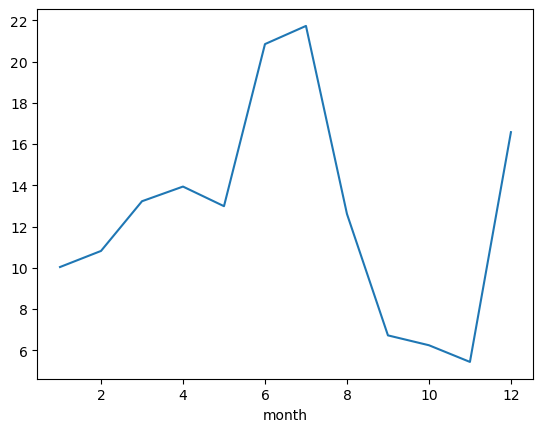

In [39]:
flights.groupby('month')['dep_delay'].mean().plot()
plt.show()

In [40]:
flights.apply(lambda x: datetime(x['year'], x['month'], x['day']).isocalendar()[1], axis=1)

0          1
1          1
2          1
3          1
4          1
          ..
336771    40
336772    40
336773    40
336774    40
336775    40
Length: 336776, dtype: int64

In [41]:
for col in planes.columns:
    print(f'{col} : {planes[col].unique()}')

tailnum : ['N10156' 'N102UW' 'N103US' ... 'N998AT' 'N998DL' 'N999DN']
year : [2004. 1998. 1999. 2002. 2003. 2005. 2006. 2000. 2001. 1994. 1995. 1996.
 1987. 2009. 2010. 1991. 1997.   nan 1965. 2007. 1990. 2013. 2008. 1992.
 1993. 1959. 1980. 2011. 2012. 1988. 1985. 1986. 1989. 1973. 1978. 1963.
 1956. 1972. 1968. 1975. 1979. 1983. 1976. 1984. 1967. 1977. 1974.]
type : ['Fixed wing multi engine' 'Fixed wing single engine' 'Rotorcraft']
manufacturer : ['EMBRAER' 'AIRBUS INDUSTRIE' 'BOEING' 'AIRBUS' 'BOMBARDIER INC' 'CESSNA'
 'JOHN G HESS' 'GULFSTREAM AEROSPACE' 'SIKORSKY' 'PIPER' 'AGUSTA SPA'
 'PAIR MIKE E' 'DOUGLAS' 'BEECH' 'BELL' 'AVIAT AIRCRAFT INC'
 'STEWART MACO' 'LEARJET INC' 'MCDONNELL DOUGLAS' 'CIRRUS DESIGN CORP'
 'HURLEY JAMES LARRY' 'KILDALL GARY' 'LAMBERT RICHARD' 'BARKER JACK L'
 'AMERICAN AIRCRAFT INC' 'ROBINSON HELICOPTER CO' 'FRIEDEMANN JON'
 'LEBLANC GLENN T' 'MARZ BARRY' 'DEHAVILLAND' 'CANADAIR' 'CANADAIR LTD'
 'MCDONNELL DOUGLAS CORPORATION' 'MCDONNELL DOUGLAS AIRCRAFT

In [42]:
print(weather.shape)
weather.isnull().sum()

(26115, 15)


origin            0
year              0
month             0
day               0
hour              0
temp              1
dewp              1
humid             1
wind_dir        460
wind_speed        4
wind_gust     20778
precip            0
pressure       2729
visib             0
time_hour         0
dtype: int64

In [43]:
flights.drop(['arr_time', 'arr_delay', 'air_time', 'dep_time'], axis=1, inplace=True)
flights.head()

,year,month,day,sched_dep_time,dep_delay,sched_arr_time,carrier,flight,tailnum,origin,dest,distance,hour,minute,time_hour
0,2013,1,1,515,2.0,819,UA,1545,N14228,EWR,IAH,1400,5,15,2013-01-01 10:00:00+00:00
1,2013,1,1,529,4.0,830,UA,1714,N24211,LGA,IAH,1416,5,29,2013-01-01 10:00:00+00:00
2,2013,1,1,540,2.0,850,AA,1141,N619AA,JFK,MIA,1089,5,40,2013-01-01 10:00:00+00:00
3,2013,1,1,545,-1.0,1022,B6,725,N804JB,JFK,BQN,1576,5,45,2013-01-01 10:00:00+00:00
4,2013,1,1,600,-6.0,837,DL,461,N668DN,LGA,ATL,762,6,0,2013-01-01 11:00:00+00:00


In [44]:
flights.drop(flights.loc[flights['dep_delay'].isnull()].index, inplace=True)
flights.shape

(328521, 15)

In [45]:
flights['dep_delay'] = flights['dep_delay'].astype('int')
flights.info()

<class 'pandas.core.frame.DataFrame'>
Index: 328521 entries, 0 to 336769
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   year            328521 non-null  int64              
 1   month           328521 non-null  int64              
 2   day             328521 non-null  int64              
 3   sched_dep_time  328521 non-null  int64              
 4   dep_delay       328521 non-null  int32              
 5   sched_arr_time  328521 non-null  int64              
 6   carrier         328521 non-null  object             
 7   flight          328521 non-null  int64              
 8   tailnum         328521 non-null  object             
 9   origin          328521 non-null  object             
 10  dest            328521 non-null  object             
 11  distance        328521 non-null  int64              
 12  hour            328521 non-null  int64              
 13  minute          328

In [46]:
def extract_week(x):
    y,w,d = datetime(x['year'], x['month'], x['day']).isocalendar()
    return d, w + (d-1)/7
    
flights['week_day'], flights['week_float'] = zip(*flights.apply(extract_week, axis=1))
flights.head()

,year,month,day,sched_dep_time,dep_delay,sched_arr_time,carrier,flight,tailnum,origin,dest,distance,hour,minute,time_hour,week_day,week_float
0,2013,1,1,515,2,819,UA,1545,N14228,EWR,IAH,1400,5,15,2013-01-01 10:00:00+00:00,2,1.142857
1,2013,1,1,529,4,830,UA,1714,N24211,LGA,IAH,1416,5,29,2013-01-01 10:00:00+00:00,2,1.142857
2,2013,1,1,540,2,850,AA,1141,N619AA,JFK,MIA,1089,5,40,2013-01-01 10:00:00+00:00,2,1.142857
3,2013,1,1,545,-1,1022,B6,725,N804JB,JFK,BQN,1576,5,45,2013-01-01 10:00:00+00:00,2,1.142857
4,2013,1,1,600,-6,837,DL,461,N668DN,LGA,ATL,762,6,0,2013-01-01 11:00:00+00:00,2,1.142857


In [47]:
flights.drop(['year','month','day','hour','minute'], axis=1, inplace=True)


In [48]:
flights['sched_arr_time'].min(), flights['sched_arr_time'].max()

(1, 2359)

In [49]:
def convert_time_to_mins(row):
    sc_dep = row['sched_dep_time']
    sc_dep = sc_dep//100*60 + sc_dep%100
    
    sc_arr = row['sched_arr_time']
    if  sc_arr < sc_dep:
        sc_arr += 2400
    sc_arr = sc_arr//100*60 + sc_arr%100
    
    dep_del = row['dep_delay']
    if dep_del >0 :
        dep_del = dep_del//100*60 + dep_del%100
    
    return sc_dep, dep_del, sc_arr
    

flights['sched_dep_time'], flights['dep_delay'], flights['sched_arr_time'] = zip(*flights.apply(convert_time_to_mins, axis=1))

In [50]:
flights['sched_travel_time'] = flights['sched_arr_time'] - flights['sched_dep_time']
flights.drop('sched_arr_time', axis=1, inplace=True)

In [51]:
flights.drop(['flight', 'dest'], axis=1, inplace=True)

In [52]:
weather.isnull().sum()

origin            0
year              0
month             0
day               0
hour              0
temp              1
dewp              1
humid             1
wind_dir        460
wind_speed        4
wind_gust     20778
precip            0
pressure       2729
visib             0
time_hour         0
dtype: int64

In [53]:
weather.drop(['year', 'month', 'day', 'hour', 'wind_gust'], axis=1, inplace=True)

In [54]:
imp = SimpleImputer(strategy='median')
cols_to_impute = ['temp','dewp','humid','wind_dir','wind_speed','pressure']
weather[cols_to_impute] = pd.DataFrame(imp.fit_transform(weather[cols_to_impute]), index=weather.index, columns=cols_to_impute)

In [55]:
we = None
for port in weather['origin'].unique():
    weather_t = weather.loc[weather['origin']==port].copy()
    weather_t.set_index('time_hour', inplace=True)
    weather_t = weather_t.asfreq('H', method='ffill')
    weather_t['time_hour'] = weather_t.index
    weather_t.reset_index(drop=True, inplace=True)
    if we is None:
        we = weather_t
    else:
        we = pd.concat([we, weather_t], ignore_index=True)
weather = we
we.isnull().sum(), we.shape

(origin        0
 temp          0
 dewp          0
 humid         0
 wind_dir      0
 wind_speed    0
 precip        0
 pressure      0
 visib         0
 time_hour     0
 dtype: int64,
 (26190, 10))

In [56]:
weather.head()

,origin,temp,dewp,humid,wind_dir,wind_speed,precip,pressure,visib,time_hour
0,EWR,39.02,26.06,59.37,270.0,10.35702,0.0,1012.0,10.0,2013-01-01 06:00:00+00:00
1,EWR,39.02,26.96,61.63,250.0,8.05546,0.0,1012.3,10.0,2013-01-01 07:00:00+00:00
2,EWR,39.02,28.04,64.43,240.0,11.50780,0.0,1012.5,10.0,2013-01-01 08:00:00+00:00
3,EWR,39.92,28.04,62.21,250.0,12.65858,0.0,1012.2,10.0,2013-01-01 09:00:00+00:00
4,EWR,39.02,28.04,64.43,260.0,12.65858,0.0,1011.9,10.0,2013-01-01 10:00:00+00:00


In [57]:
flights = pd.merge(flights, weather,  how='left', left_on=['origin','time_hour'], right_on = ['origin','time_hour'])
flights.shape

(328521, 18)

In [58]:
flights = flights.loc[flights['temp'].isnull() == False]

In [59]:
flights.isnull().sum().sum()

0

In [60]:
planes.isnull().sum()

tailnum            0
year              70
type               0
manufacturer       0
model              0
engines            0
seats              0
speed           3299
engine             0
dtype: int64

In [61]:
planes.loc[planes['year'].isnull(), 'year'] = -1.0

In [62]:
pl_yrs = planes.groupby('model')['year'].median()
planes['year'] = planes.apply(lambda row: pl_yrs[row['model']] if row['year'] == -1 else row['year'], axis=1)
planes['year'] = planes['year'].astype('int')

In [63]:
planes.drop(['manufacturer', 'model', 'speed'], axis=1, inplace=True)
planes

,tailnum,year,type,engines,seats,engine
0,N10156,2004,Fixed wing multi engine,2,55,Turbo-fan
1,N102UW,1998,Fixed wing multi engine,2,182,Turbo-fan
2,N103US,1999,Fixed wing multi engine,2,182,Turbo-fan
3,N104UW,1999,Fixed wing multi engine,2,182,Turbo-fan
4,N10575,2002,Fixed wing multi engine,2,55,Turbo-fan
...,...,...,...,...,...,...
3317,N997AT,2002,Fixed wing multi engine,2,100,Turbo-fan
3318,N997DL,1992,Fixed wing multi engine,2,142,Turbo-fan
3319,N998AT,2002,Fixed wing multi engine,2,100,Turbo-fan
3320,N998DL,1992,Fixed wing multi engine,2,142,Turbo-jet


In [64]:
flights = pd.merge(flights, planes,  how='left', left_on=['tailnum'], right_on = ['tailnum'])
flights.shape

(327607, 23)

In [65]:
flights.loc[flights['year'].isnull(), 'tailnum']

9         N3ALAA
14        N3DUAA
18        N542MQ
21        N730MQ
25        N9EAMQ
           ...  
327537    N3CUAA
327557    N535MQ
327564    N528MQ
327587    N807MQ
327596    N532MQ
Name: tailnum, Length: 48418, dtype: object

In [66]:
flights.drop(['tailnum', 'time_hour'], axis=1, inplace=True)
flights.head()

,sched_dep_time,dep_delay,carrier,origin,distance,week_day,week_float,sched_travel_time,temp,dewp,...,wind_dir,wind_speed,precip,pressure,visib,year,type,engines,seats,engine
0,315,2,UA,EWR,1400,2,1.142857,184,39.02,28.04,...,260.0,12.65858,0.0,1011.9,10.0,1999.0,Fixed wing multi engine,2.0,149.0,Turbo-fan
1,329,4,UA,LGA,1416,2,1.142857,181,39.92,24.98,...,250.0,14.96014,0.0,1011.4,10.0,1998.0,Fixed wing multi engine,2.0,149.0,Turbo-fan
2,340,2,AA,JFK,1089,2,1.142857,190,39.02,26.96,...,260.0,14.96014,0.0,1012.1,10.0,1990.0,Fixed wing multi engine,2.0,178.0,Turbo-fan
3,345,-1,B6,JFK,1576,2,1.142857,277,39.02,26.96,...,260.0,14.96014,0.0,1012.1,10.0,2012.0,Fixed wing multi engine,2.0,200.0,Turbo-fan
4,360,-6,DL,LGA,762,2,1.142857,157,39.92,24.98,...,260.0,16.11092,0.0,1011.7,10.0,1991.0,Fixed wing multi engine,2.0,178.0,Turbo-fan


In [236]:
flights = flights.loc[flights['year'].isnull() == False]

In [237]:
# I have tried to keep carrier data... but execution was taking tooooooo long... so removing it instead
flights.drop('carrier', axis=1, inplace=True)

KeyError: "['carrier'] not found in axis"

In [238]:
flights = pd.get_dummies(flights, drop_first=True)
flights.shape

(279189, 26)

In [239]:
flights.isnull().sum().sum()

0

In [71]:
delay_time_threshold = 10
flights['delayed'] = flights['dep_delay'].map(lambda time : 1 if time > delay_time_threshold else 0)
flights.drop('dep_delay', axis=1, inplace=True)

In [72]:
X = flights.drop('delayed', axis=1)
y = flights['delayed']
X.shape, y.shape

((279189, 25), (279189,))

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2021, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((251270, 25), (27919, 25), (251270,), (27919,))

In [74]:
sc = StandardScaler()
X_train_sc = pd.DataFrame(sc.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_sc = pd.DataFrame(sc.transform(X_test), index=X_test.index, columns=X_test.columns)

In [81]:
X_test.head()

,sched_dep_time,distance,week_day,week_float,sched_travel_time,temp,dewp,humid,wind_dir,wind_speed,...,seats,origin_JFK,origin_LGA,type_Fixed wing single engine,type_Rotorcraft,engine_Reciprocating,engine_Turbo-fan,engine_Turbo-jet,engine_Turbo-prop,engine_Turbo-shaft
243586,781,199,1,27.000000,70,75.92,73.04,90.80,140.0,6.90468,...,55.0,False,False,False,False,False,True,False,False,False
292265,1246,416,4,34.428571,102,75.20,69.80,83.32,220.0,8.05546,...,55.0,False,False,False,False,False,True,False,False,False
213334,659,1400,3,22.285714,161,69.98,64.04,82.86,230.0,6.90468,...,179.0,False,False,False,False,False,False,True,False,False
249458,510,419,1,28.000000,105,78.98,66.02,64.54,310.0,10.35702,...,22.0,False,True,False,False,False,False,True,False,False
276366,420,1076,2,32.142857,189,68.00,57.92,70.15,50.0,4.60312,...,142.0,False,True,False,False,False,True,False,False,False


In [82]:
X_train.head()

,sched_dep_time,distance,week_day,week_float,sched_travel_time,temp,dewp,humid,wind_dir,wind_speed,...,seats,origin_JFK,origin_LGA,type_Fixed wing single engine,type_Rotorcraft,engine_Reciprocating,engine_Turbo-fan,engine_Turbo-jet,engine_Turbo-prop,engine_Turbo-shaft
69841,495,2248,7,46.857143,157,57.02,53.60,93.65,100.0,8.05546,...,178.0,True,False,False,False,False,True,False,False,False
166984,720,541,1,15.000000,114,60.98,42.98,51.48,190.0,10.35702,...,179.0,True,False,False,False,False,True,False,False,False
132659,929,2227,5,9.571429,166,44.06,24.98,46.73,310.0,12.65858,...,200.0,False,False,False,False,False,True,False,False,False
224880,1340,1598,1,24.000000,229,66.02,64.94,96.31,170.0,8.05546,...,200.0,True,False,False,False,False,True,False,False,False
160782,1120,2422,1,14.000000,205,46.94,32.00,55.85,320.0,10.35702,...,189.0,True,False,False,False,False,False,True,False,False


In [241]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

In [242]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [243]:
results = pd.DataFrame(columns=["Model Name", "Accuracy", "F1-score", "ROC"])

In [244]:
def draw_roc(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate=False)
    auc_score = metrics.roc_auc_score(actual, probs)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr,label="ROC Curve (area = %0.2f)" % auc_score)
    plt.plot([0,1], [0,1], "k--")
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False positive rate or [1 - true Negative rate]")
    plt.ylabel("True positive Rate")
    plt.title("Receiver operating characteristics")
    plt.legend(loc="lower right")
    plt.show()

# Logistic Regression

In [245]:
from sklearn.linear_model import LogisticRegression

In [246]:
logistic = LogisticRegression(C=0.01)
logistic_model = logistic.fit(X_train, y_train)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [247]:

def display_test_results(model_name, model):
    y_test_pred = model.predict(X_test)

    # Confusion Matrix

    print("--------------Confusion Matrix--------------")
    c_matrix =metrics.confusion_matrix(y_test, y_test_pred)
    print(c_matrix)

    cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
    cm_display.plot(cmap=plt.cm.Blues)
    plt.show()

    # Classification report:
    print("--------------Classification Report--------------")
    print(classification_report(y_test, y_test_pred))

    print("--------------More Specific Classification Report--------------")
    TP = c_matrix[1,1]
    TN = c_matrix[0,0]
    FP = c_matrix[0,1]
    FN = c_matrix[1,0]

    #Accuracy
    print("Accuracy:-", metrics.accuracy_score(y_test, y_test_pred))


    # Sensitivity

    print("Sensitivity :-", TP/float(TP+TN))

    # Specificity 

    print("Specificity :-", TN/float(TN+FP))

    # f1 Score

    print("F1-Score :-", f1_score(y_test, y_test_pred))

    # Predicted Probability

    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    # roc_auc

    print("--------------ROC--------------")
    roc_auc = metrics.roc_auc_score(y_test, y_test_pred_proba)

    # Plot ROC Curve

    draw_roc(y_test, y_test_pred_proba)

    # Add all Metrics score in final results store

    results.loc[len(results)] = [model_name, metrics.accuracy_score(y_test, y_test_pred), f1_score(y_test, y_test_pred), roc_auc(y_test, y_test_pred)]

--------------Confusion Matrix--------------
[[40191  1329]
 [12694  1624]]


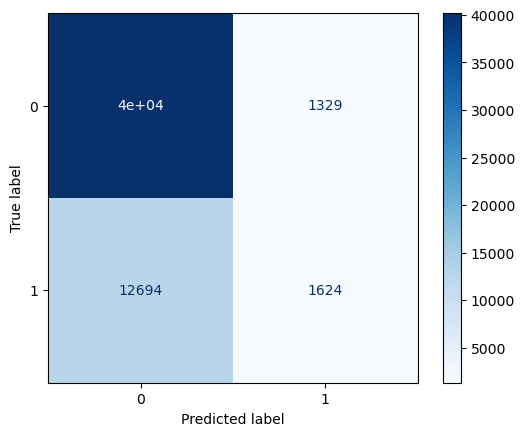

--------------Classification Report--------------
              precision    recall  f1-score   support

           0       0.76      0.97      0.85     41520
           1       0.55      0.11      0.19     14318

    accuracy                           0.75     55838
   macro avg       0.65      0.54      0.52     55838
weighted avg       0.71      0.75      0.68     55838

--------------More Specific Classification Report--------------
Accuracy:- 0.7488627816182528
Sensitivity :- 0.03883773765395193
Specificity :- 0.9679913294797687
F1-Score :- 0.18806091135429331
--------------ROC--------------


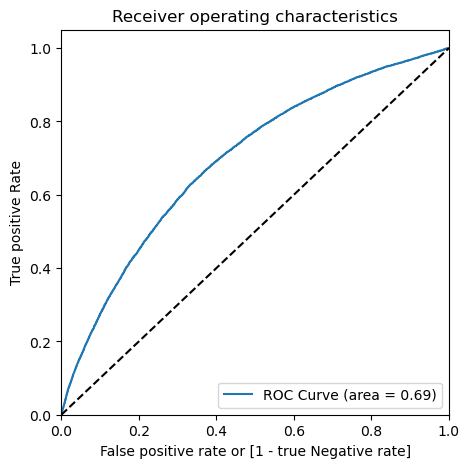

TypeError: 'numpy.float64' object is not callable

In [208]:
display_test_results("LogisticRegression", logistic_model)

In [209]:
def display_test_results(model_name, model):
    y_test_pred = model.predict(X_test)

    # Confusion Matrix
    print("--------------Confusion Matrix--------------")
    c_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    print(c_matrix)

    cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
    cm_display.plot(cmap=plt.cm.Blues)
    plt.show()

    # Classification report:
    print("--------------Classification Report--------------")
    print(classification_report(y_test, y_test_pred))

    print("--------------More Specific Classification Report--------------")
    TP = c_matrix[1, 1]
    TN = c_matrix[0, 0]
    FP = c_matrix[0, 1]
    FN = c_matrix[1, 0]

    # Accuracy
    print("Accuracy:-", metrics.accuracy_score(y_test, y_test_pred))

    # Sensitivity
    print("Sensitivity :-", TP / float(TP + TN))

    # Specificity
    print("Specificity :-", TN / float(TN + FP))

    # f1 Score
    print("F1-Score :-", f1_score(y_test, y_test_pred))

    # Predicted Probability
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    # roc_auc
    print("--------------ROC--------------")
    roc_auc = metrics.roc_auc_score(y_test, y_test_pred_proba)

    # Plot ROC Curve
    draw_roc(y_test, y_test_pred_proba)

    # Add all Metrics score in final results store
    results.loc[len(results)] = [model_name, metrics.accuracy_score(y_test, y_test_pred), f1_score(y_test, y_test_pred), roc_auc]

--------------Confusion Matrix--------------
[[40191  1329]
 [12694  1624]]


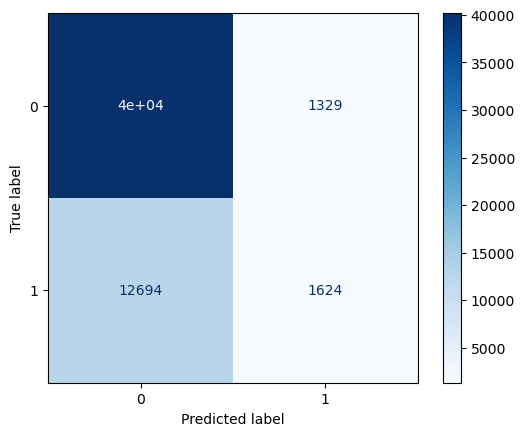

--------------Classification Report--------------
              precision    recall  f1-score   support

           0       0.76      0.97      0.85     41520
           1       0.55      0.11      0.19     14318

    accuracy                           0.75     55838
   macro avg       0.65      0.54      0.52     55838
weighted avg       0.71      0.75      0.68     55838

--------------More Specific Classification Report--------------
Accuracy:- 0.7488627816182528
Sensitivity :- 0.03883773765395193
Specificity :- 0.9679913294797687
F1-Score :- 0.18806091135429331
--------------ROC--------------


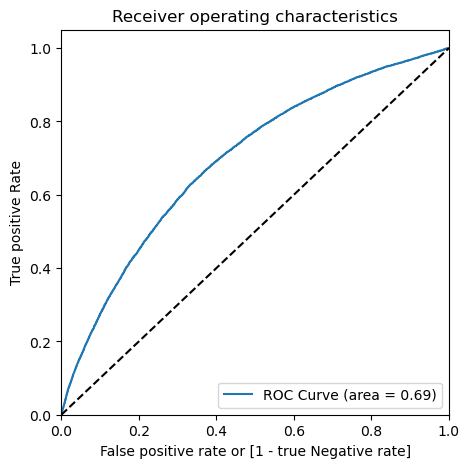

In [210]:
display_test_results("LogisticRegression", logistic_model)

# XGBoost

In [211]:
params ={ "learning rate" : 0.2,
         "max_depth": 2,
         "n_estimator": 200,
         "subsample": 0.9,
         "objective" : "binary : logistic"}

In [212]:
xgb_model = XGBClassifier(params=params)
xgb_model.fit(X_train, y_train)

[20:47:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1,
              params={'learning rate': 0.2, 'max_depth': 2, 'n_estimator': 200,
                      'objective': 'binary : logistic', 'subsample': 0.9},
              predictor='auto', random_state=0, reg_alpha=0, ...)

--------------Confusion Matrix--------------
[[39258  2262]
 [ 9388  4930]]


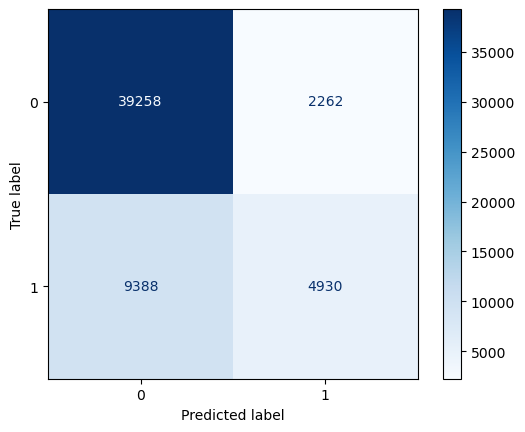

--------------Classification Report--------------
              precision    recall  f1-score   support

           0       0.81      0.95      0.87     41520
           1       0.69      0.34      0.46     14318

    accuracy                           0.79     55838
   macro avg       0.75      0.64      0.66     55838
weighted avg       0.78      0.79      0.77     55838

--------------More Specific Classification Report--------------
Accuracy:- 0.7913607220889001
Sensitivity :- 0.11156875169729338
Specificity :- 0.9455202312138729
F1-Score :- 0.45839144583914454
--------------ROC--------------


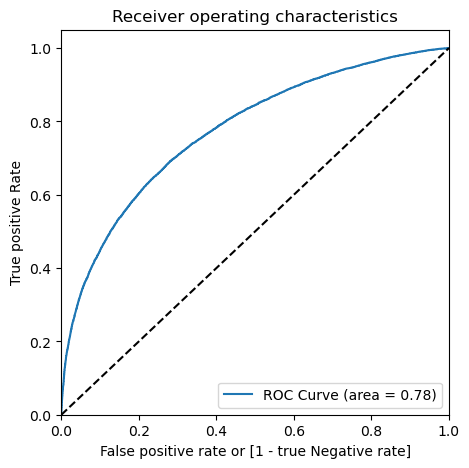

In [213]:
display_test_results("XG Boost", xgb_model)

# Decision Tree

In [229]:
from sklearn.tree import DecisionTreeClassifier

In [230]:
# Model with optimal hyperameters
decision_tree_model = DecisionTreeClassifier(criterion= "gini",
                                             random_state=100,
                                             max_depth=5,
                                             min_samples_leaf=100,
                                             min_samples_split=100)
decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, min_samples_split=100,
                       random_state=100)

In [235]:
results.sort_values(by="ROC", ascending=False)
results


,Model Name,Accuracy,F1-score,ROC
1,LogisticRegression,0.748863,0.188061,0.694148
2,XG Boost,0.791361,0.458391,0.775728
3,Neural Network,0.776335,0.371486,0.746255
4,K Nearest Neighbors,0.764426,0.455772,0.709163
5,Random Forest,0.743580,0.000000,0.553440
6,Decision Tree,0.743580,0.000000,0.500000


--------------Confusion Matrix--------------
[[40105  1415]
 [11945  2373]]


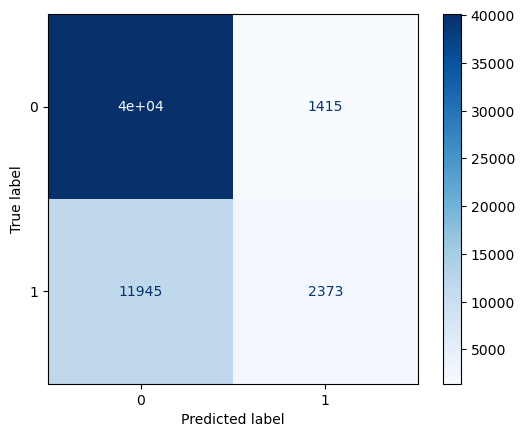

--------------Classification Report--------------
              precision    recall  f1-score   support

           0       0.77      0.97      0.86     41520
           1       0.63      0.17      0.26     14318

    accuracy                           0.76     55838
   macro avg       0.70      0.57      0.56     55838
weighted avg       0.73      0.76      0.70     55838

--------------More Specific Classification Report--------------
Accuracy:- 0.7607364160607472
Sensitivity :- 0.055864212062714816
Specificity :- 0.9659200385356455
F1-Score :- 0.2621230531315586
--------------ROC--------------


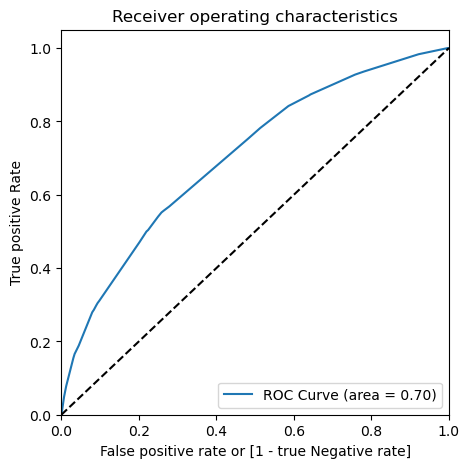

TypeError: 'numpy.float64' object is not callable

In [248]:
display_test_results("Decision Tree", decision_tree_model)

,Model Name,Accuracy,F1-score,ROC
0,LogisticRegression,0.748863,0.188061,0.694148
1,XG Boost,0.791361,0.458391,0.775728
2,XG Boost,0.791361,0.458391,0.775728
3,Decision Tree,0.760736,0.262123,0.703584


# Random Forest

In [224]:
from sklearn.ensemble import RandomForestClassifier

In [225]:
random_forest_model = RandomForestClassifier(bootstrap=True,
                                             max_depth=5,
                                             min_samples_leaf=50,
                                             min_samples_split=50,
                                             max_features=10,
                                             n_estimators=100)
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=10, min_samples_leaf=50,
                       min_samples_split=50)

In [228]:
results.index = range(1, len(results) + 1)
results


,Model Name,Accuracy,F1-score,ROC
1,LogisticRegression,0.748863,0.188061,0.694148
2,XG Boost,0.791361,0.458391,0.775728
3,Neural Network,0.776335,0.371486,0.746255
4,K Nearest Neighbors,0.764426,0.455772,0.709163
5,Random Forest,0.743580,0.000000,0.553440


--------------Confusion Matrix--------------
[[40682   838]
 [12379  1939]]


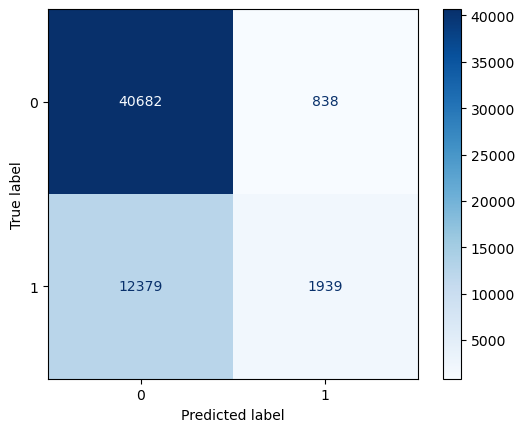

--------------Classification Report--------------
              precision    recall  f1-score   support

           0       0.77      0.98      0.86     41520
           1       0.70      0.14      0.23     14318

    accuracy                           0.76     55838
   macro avg       0.73      0.56      0.54     55838
weighted avg       0.75      0.76      0.70     55838

--------------More Specific Classification Report--------------
Accuracy:- 0.7632973960385401
Sensitivity :- 0.045494005302550385
Specificity :- 0.9798169556840077
F1-Score :- 0.22684995612752268
--------------ROC--------------


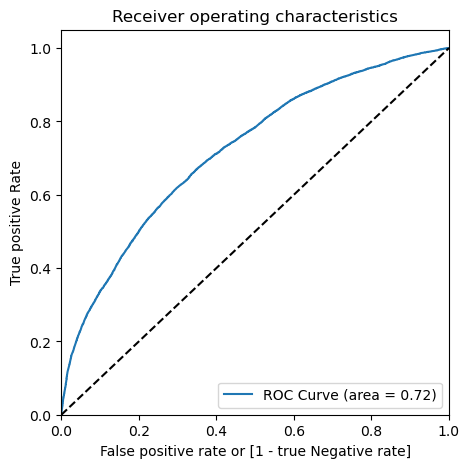

TypeError: 'numpy.float64' object is not callable

In [249]:
display_test_results("Random Forest", random_forest_model)

In [198]:
from sklearn.neighbors import KNeighborsClassifier


KNear_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

# Fit the model to the training data
KNear_model.fit(X_train, y_train)

In [251]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Assuming you have X_train and y_train datasets
# Replace X_train and y_train with your actual training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming you have a DataFrame with features (X) and target variable (y)
# Replace X and y with your actual feature and target variable

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the display_test_results function
def display_test_results(model_name, model):
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Store the results in the 'results' DataFrame
    results.loc[len(results) + 1] = [model_name, accuracy, f1, roc_auc]

    # Display the results
    print(f"--------------{model_name} Results--------------")
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("\n")

# Create and train the KNN model
KNear_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
KNear_model.fit(X_train_scaled, y_train)

# Display and store results for K Nearest Neighbors model
display_test_results("K Nearest Neighbors", KNear_model)

# Set the index of the 'results' DataFrame to start from 1
results.index = range(1, len(results) + 1)

# Display the overall results DataFrame
print("--------------Overall Results--------------")
print(results)


--------------K Nearest Neighbors Results--------------
Accuracy: 0.7644256599448405
F1 Score: 0.45577161770790237
ROC AUC Score: 0.7091625390490324


--------------Overall Results--------------
            Model Name  Accuracy  F1-score       ROC
1  K Nearest Neighbors  0.764426  0.455772  0.709163


In [223]:
results.index = range(1, len(results) + 1)
results


,Model Name,Accuracy,F1-score,ROC
1,LogisticRegression,0.748863,0.188061,0.694148
2,XG Boost,0.791361,0.458391,0.775728
3,Neural Network,0.776335,0.371486,0.746255
4,K Nearest Neighbors,0.764426,0.455772,0.709163


## K Nearest Neighbours

In [250]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming you have a DataFrame with features (X) and target variable (y)
# Replace X and y with your actual feature and target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Epoch 1/10
5584/5584 [==============================] - 14s 2ms/step - loss: 0.5119 - accuracy: 0.7618 - val_loss: 0.5064 - val_accuracy: 0.7641
Epoch 2/10
5584/5584 [==============================] - 11s 2ms/step - loss: 0.5017 - accuracy: 0.7687 - val_loss: 0.5023 - val_accuracy: 0.7684
Epoch 3/10
5584/5584 [==============================] - 10s 2ms/step - loss: 0.4979 - accuracy: 0.7711 - val_loss: 0.4996 - val_accuracy: 0.7679
Epoch 4/10
5584/5584 [==============================] - 11s 2ms/step - loss: 0.4949 - accuracy: 0.7734 - val_loss: 0.4975 - val_accuracy: 0.7698
Epoch 5/10
5584/5584 [==============================] - 12s 2ms/step - loss: 0.4925 - accuracy: 0.7747 - val_loss: 0.4955 - val_accuracy: 0.7705
Epoch 6/10
5584/5584 [==============================] - 12s 2ms/step - loss: 0.4906 - accuracy: 0.7762 - val_loss: 0.4942 - val_accuracy: 0.7733
Epoch 7/10
5584/5584 [==============================] - 11s 2ms/step - loss: 0.4894 - accuracy: 0.7774 - val_loss: 0.4933 - val_ac

In [220]:
# Assuming you have a DataFrame with features (X) and target variable (y)
# Replace X and y with your actual feature and target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
results.loc[len(results)] = ["Neural Network", accuracy, f1, roc_auc]


print("Accuracy:", accuracy)
print("Neural Network:")
print(classification_report(y_test, y_pred))



Epoch 1/10
5584/5584 [==============================] - 15s 2ms/step - loss: 0.5120 - accuracy: 0.7618 - val_loss: 0.5111 - val_accuracy: 0.7608
Epoch 2/10
5584/5584 [==============================] - 10s 2ms/step - loss: 0.5025 - accuracy: 0.7682 - val_loss: 0.5033 - val_accuracy: 0.7670
Epoch 3/10
5584/5584 [==============================] - 11s 2ms/step - loss: 0.4984 - accuracy: 0.7717 - val_loss: 0.5007 - val_accuracy: 0.7691
Epoch 4/10
5584/5584 [==============================] - 11s 2ms/step - loss: 0.4954 - accuracy: 0.7733 - val_loss: 0.4989 - val_accuracy: 0.7704
Epoch 5/10
5584/5584 [==============================] - 11s 2ms/step - loss: 0.4932 - accuracy: 0.7750 - val_loss: 0.4954 - val_accuracy: 0.7711
Epoch 6/10
5584/5584 [==============================] - 11s 2ms/step - loss: 0.4910 - accuracy: 0.7765 - val_loss: 0.4968 - val_accuracy: 0.7720
Epoch 7/10
5584/5584 [==============================] - 10s 2ms/step - loss: 0.4897 - accuracy: 0.7770 - val_loss: 0.4945 - val_ac

In [221]:
results.index = range(1, len(results) + 1)
results


,Model Name,Accuracy,F1-score,ROC
1,LogisticRegression,0.748863,0.188061,0.694148
2,XG Boost,0.791361,0.458391,0.775728
3,Neural Network,0.776335,0.371486,0.746255


In [201]:
results.sort_values(by="ROC", ascending=False)
results

,Model Name,Accuracy,F1-score,ROC
1,LogisticRegression,0.748863,0.188061,0.694148
2,XG Boost,0.791361,0.458391,0.775728
3,Decision Tree,0.760736,0.262123,0.703584
4,K Nearest Neighbors,0.776460,0.371486,0.746255
5,K Nearest Neighbors,0.776460,0.371486,0.746255


## Gaussian NB

In [76]:
nb = GaussianNB()
kfold = StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)
scores = cross_val_score(nb, X_train, y_train, cv=kfold, scoring='roc_auc', verbose=3)

scores.mean(), scores.std()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.675) total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ................................ score: (test=0.669) total time=   0.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END ................................ score: (test=0.677) total time=   0.2s
[CV] END ................................ score: (test=0.677) total time=   0.2s
[CV] END ................................ score: (test=0.675) total time=   0.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished


(0.6746140193437411, 0.0028318902475703432)

# Decision Tree

In [77]:
kfold = StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)
dtree = DecisionTreeClassifier()
parameters = {'max_depth' : np.arange(3, 31,5),
             'min_samples_split' : np.arange(2,23,5),
             'min_samples_leaf' : np.arange(2,23,5)}

cv_dtree = GridSearchCV(dtree, param_grid=parameters, cv=kfold, scoring='roc_auc', verbose=1, n_jobs=8)
cv_dtree.fit(X_train,y_train)
cv_dtree.best_params_, cv_dtree.best_score_, cv_dtree.best_estimator_

Fitting 5 folds for each of 150 candidates, totalling 750 fits


({'max_depth': 13, 'min_samples_leaf': 22, 'min_samples_split': 12},
 0.7335416504853077,
 DecisionTreeClassifier(max_depth=13, min_samples_leaf=22, min_samples_split=12))

In [78]:
cv_dtree.best_params_, cv_dtree.best_score_, cv_dtree.best_estimator_

({'max_depth': 13, 'min_samples_leaf': 22, 'min_samples_split': 12},
 0.7335416504853077,
 DecisionTreeClassifier(max_depth=13, min_samples_leaf=22, min_samples_split=12))

In [79]:
y_pred_dtree = cv_dtree.predict_proba(X_test)
roc_auc_score(y_test, y_pred_dtree[:,-1])

0.738343461595343

# Random Forest

In [80]:
X_tr,X_te,y_tr,y_te = train_test_split(X_train,y_train,random_state=2021, test_size=0.2, stratify=y_train)
for depth in [10,15,20,25]:
    model_rf = RandomForestClassifier(random_state=2021, max_depth=depth)
    model_rf.fit(X_tr, y_tr)
    y_pr = model_rf.predict_proba(X_te)
    print(roc_auc_score(y_te, y_pr[:,-1]))

0.7510060158227099
0.7689814767890756
0.7673455584333004
0.7615168103209261


In [ ]:
model_rf = RandomForestClassifier(random_state=2021, max_depth=20)
model_rf.fit(X_train, y_train)

In [127]:
results

,Model Name,Accuracy,F1-score,ROC
0,K Nearest Neighbors,0.77578,0.371486,0.746255


# Linear Quadradic discriminator

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
kfold = StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)

lda = LinearDiscriminantAnalysis()
scores = cross_val_score(lda, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f'linear : mean={scores.mean()}, std_dev={scores.std()}')

qda = QuadraticDiscriminantAnalysis()
scores = cross_val_score(qda, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f'linear : mean={scores.mean()}, std_dev={scores.std()}')

In [ ]:
lda.fit(X_train, y_train)
y_pred_da = lda.predict_proba(X_test)
roc_auc_score(y_test, y_pred_da[:,-1])

# Extreme Gradient Boost(XGB)

In [ ]:
X_tr,X_te,y_tr,y_te = train_test_split(X_train,y_train,random_state=2021, test_size=0.2, stratify=y_train)
for depth in [10,15,20,25]:
    clf = XGBClassifier(random_state=2021, n_jobs=8, use_label_encoder=False, verbosity=0, silent=True, 
                        learning_rate=0.1, 
                        max_depth=depth)
    clf.fit(X_tr, y_tr)
    y_pr = clf.predict_proba(X_te)
    print(roc_auc_score(y_te, y_pr[:,-1]))

In [ ]:
X_tr,X_te,y_tr,y_te = train_test_split(X_train,y_train,random_state=2021, test_size=0.2, stratify=y_train)
for learn_rate in [0.05, 0.1, 0.15, 0.2, 0.25]:
    clf = XGBClassifier(random_state=2021, n_jobs=8, use_label_encoder=False, verbosity=0, silent=True, 
                        learning_rate=learn_rate,
                        max_depth=10)
    clf.fit(X_tr, y_tr)
    y_pr = clf.predict_proba(X_te)
    print(roc_auc_score(y_te, y_pr[:,-1]))

In [ ]:
clf = XGBClassifier(random_state=2021, n_jobs=8, use_label_encoder=False, verbosity=0, silent=True, 
                    learning_rate=0.1,
                    max_depth=10)
clf.fit(X_train, y_train)
y_pred_xgb = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_xgb[:,-1])